# TPU v3

Compared to GPUs

*   Faster communication, greater internode communication bandwidth( 2D mesh tourus)
*   Less memory
*   Tends to have a higher idle power consumption
*   Typically use even bigger batch size to take advantage of even more parallelized computation


[Google TPU Specifications](https://cloud.google.com/tpu/docs/system-architecture-tpu-vm)

Peak compute per chip:	123 teraflops (bf16)

Measured min/mean/max power: 	123/220/262 W

hardware FLOPs utilization of [PaLM](https://arxiv.org/pdf/2204.02311.pdf) is 57.8%
540B parameters, uses 6144 TPU v4 chips/
###Gopher 280B
Used 4096 TPU v3 at 32.5% Model FLOPS utilization/
In carbon emissions figure 5, models using TPU v3 has flop utilization of around 32.5%.

###[TPU datacenter performance](https://arxiv.org/pdf/1704.04760.pdf)
TPU's have poor energy proportionality
  At 10% load, the TPU uses 88% of the power it uses at 100%

###[TPU v4](https://arxiv.org/pdf/2304.01433.pdf)


#Total FLOPS needed to train Transformer models
###[Training Compute-Optimal Large Language Models](https://arxiv.org/pdf/2203.15556.pdf) proves approximation for transformer models
### FLOPs = 6ND
N = number of parameters\
D = training tokens\
Since backward pass costs double of forward pass

In [1]:
def training_flops(parameter_b, token_t):
  # total training flops (E21)
  return 6 * token_t * parameter_b

def training_hours(training_flops, num_tpu, max_flops, util_rate):

  # assuming 32.5% flop utilization (tera, E12)
  tpu_flops = util_rate * max_flops * num_tpu

  training_seconds = training_flops / tpu_flops * 1000000000
  return training_seconds / 60 / 60

def training_energy(num_tpu, training_hours, pue,  mean_watts):
  tpu_energy = mean_watts * num_tpu
  training_days = training_hours / 24
  return training_hours * tpu_energy * pue / 1000000

def prediction_error(predicted, measured):
  # calculate error
  return (predicted - measured) / measured

# Embodied Carbon of TPUs
[TPU v4](https://arxiv.org/pdf/2304.01433.pdf)

\begin{align}
\ CO2e_{embo} &= \sum_{i\in \text{ {cpu, gpu, mem, ssd}}}\frac{time_i}{lifetime_i} \cdot \text{emb_chip}_i
\end{align}

TPU v3
* 16nm node
* Die Size of < 700 mm2
* 8 chips per CPU host

TPU v2
* 16nm node
* Die Size of < 625 mm2
* 8 chips per CPU host


Assume usage of Dual AMD Rome 7742
Foundry: TSMC
Process Size: 7 nm
Die Size: 74 mm²



In [2]:
def embodied_energy_tpu(tpu_num, tpu_version):
  cpu_num = tpu_num / 8

  if tpu_version == 'TPU v2':
    die_area = 7
  elif tpu_version == 'TPU v3':
    die_area = 6.25
  else:
    die_area = 0
    print('what')
  # 1kgCO2 per cm2
  tpu_carbon = tpu_num * die_area * 1
  cpu_carbon = cpu_num * 0.7 * 1.6
  # return in tons
  return (tpu_carbon + cpu_carbon) / 1000

In [3]:
# train time in days
# assuming 100 %uptime 0% idle time
# 5 year device lifetime
# tons of CO2
def embodied_energy(train_hours, num_tpu, tpu_version):
  return embodied_energy_tpu(num_tpu, tpu_version) * train_hours / (5 * 365 * 24)

# Populating table using emperical data from "Carbon Emissions"


In [4]:
import pandas as pd

table4 = {
  "Model": ["Transformer(Big)", "Evolved Transformer(Medium)", "Evolved Transformer NAS", "T5", "Meena", "Gshard 600B", "Switch Transformer", "GPT-3"],
  "Number of Parameters (B)": [0.21, 0.13, 0.064, 11, 2.6, 619, 1500, 175],
  "Percent of model activated on every token": [100, 100, 100, 100, 100, 0.25, 100, 100],
  "Datacenter of original experiment": ["Google Iowa Council Bluffs", "Google Iowa Council Bluffs", "Google Georgia", "Google Taiwan", "Google Georgia", "Google North Carolina", "Google Georgia", "Microsoft"],
  "Datacenter Net CO2e/KWh (kg/KWh)": [0.08, 0.08, 0.431, 0.545, 0.415, 0.177, 0.330, 0.429],
  "Datacenter PUE": [1.11, 1.11, 1.10, 1.12, 1.09, 1.09, 1.10, 1.10],
  "Processor": ["TPU v2", "TPU v2", "TPU v2", "TPU v3", "TPU v3", "TPU v3", "TPU v3", "V100"],
  "Chip Thermal Design Power (Watts)": [280, 280, 280, 450, 450, 450, 450, 300],
  "Measured System Average Power per Accelerator (W)": [229, 227, 208, 310, 289, 288, 245, 330],
  "Measured Performance (TFLOPS/s)": [28.8, 24, 24.8, 45.6, 42.3, 48, 34.4, 24.6],
  "Number of Chips": [8, 8, 200, 512, 1024, 1024, 1024, 10000],
  "Training time (days)": [0.81, 0.62, 6.8, 20, 30, 3.1, 27, 14.8]
}

#load data into a DataFrame object:
t4 = pd.DataFrame(table4)

In [5]:
t4['Total Computation (TFLOP)'] = ''
for i in t4.index:
  t4['Total Computation (TFLOP)'][i] = t4['Measured Performance (TFLOPS/s)'][i] * t4['Number of Chips'][i] * t4['Training time (days)'][i] * 24 * 60 * 60
t4['Energy Consumption (MWh)'] = ''
for i in t4.index:
  t4['Energy Consumption (MWh)'][i] = t4['Datacenter PUE'][i] * t4['Number of Chips'][i] * t4['Measured System Average Power per Accelerator (W)'][i] * t4['Training time (days)'][i] * 24 / 1000000
t4['Net tCO2 for Model Training'] = ''
for i in t4.index:
  t4['Net tCO2 for Model Training'][i] = t4['Energy Consumption (MWh)'][i] * t4["Datacenter Net CO2e/KWh (kg/KWh)"][i]

<ipython-input-5-e0cdb0f02694>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['Total Computation (TFLOP)'][i] = t4['Measured Performance (TFLOPS/s)'][i] * t4['Number of Chips'][i] * t4['Training time (days)'][i] * 24 * 60 * 60
<ipython-input-5-e0cdb0f02694>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['Energy Consumption (MWh)'][i] = t4['Datacenter PUE'][i] * t4['Number of Chips'][i] * t4['Measured System Average Power per Accelerator (W)'][i] * t4['Training time (days)'][i] * 24 / 1000000
<ipython-input-5-e0cdb0f02694>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

# CO2 Emission Prediction with Assumptions Below

In [6]:
# initialize prediction columns
t4['flop prediction'] = ''
t4['training time prediction'] = ''
t4['energy prediction'] = ''
t4['prediction error'] = ''
t4['embodied prediction'] = ''
t4['predicted tCO2'] = ''

# initialize assumption columns
t4['tokens(trillions)'] = ''
t4['max flops'] = ''
t4['mean watts'] = ''
t4['utilization rate'] = ''

#[ Meena](https://arxiv.org/pdf/2001.09977.pdf)

*   10T tokens
*   2.6B parameters
*   1024 TPU v3 chips
*   Trained in Google Georgia



In [7]:
# add assumptions
t4['tokens(trillions)'][4] = 10
t4['max flops'][4] = 123
t4['mean watts'][4] = 220
t4['utilization rate'][4] = 0.325

<ipython-input-7-6b41a9332c8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['tokens(trillions)'][4] = 10
<ipython-input-7-6b41a9332c8c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['max flops'][4] = 123
<ipython-input-7-6b41a9332c8c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['mean watts'][4] = 220
<ipython-input-7-6b41a9332c8c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

#[T5](https://arxiv.org/pdf/1910.10683.pdf)

* 1 Trillion tokens
* 11B parameters
* 512 TPU v3 chips
* Trained in Google Taiwan

In [8]:
# add assumptions
t4['tokens(trillions)'][3] = 1
t4['max flops'][3] = 123
t4['mean watts'][3] = 220
t4['utilization rate'][3] = 0.325

<ipython-input-8-1761a79cf770>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['tokens(trillions)'][3] = 1
<ipython-input-8-1761a79cf770>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['max flops'][3] = 123
<ipython-input-8-1761a79cf770>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['mean watts'][3] = 220
<ipython-input-8-1761a79cf770>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

# Gshard

* 600 Billion Mixtures of Experts model
* Trained on 1.2 Trillion tokens ( 300k+ steps, 4M tokens/step)
* Only sparsely activated since it chooses the most compatible expert for each problem


In [9]:
t4['tokens(trillions)'][5] = 1.2
t4['max flops'][5] = 123
t4['mean watts'][5] = 220
t4['utilization rate'][5] = 0.325

percent_activated = 0.25 / 100



<ipython-input-9-43a430a7bf85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['tokens(trillions)'][5] = 1.2
<ipython-input-9-43a430a7bf85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['max flops'][5] = 123
<ipython-input-9-43a430a7bf85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['mean watts'][5] = 220
<ipython-input-9-43a430a7bf85>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

# Switch Transformer (Switch-C)


*   Only uses one expert per layer, hence the name switch
*   C4 dataset, 500k steps with batch size of 2 ^ 20th (about 0.5B tokens)
* Compared with dense T5 models and flop matched through development
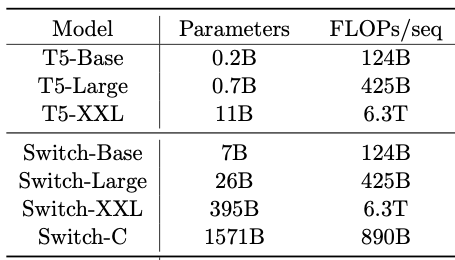

* Although Switch-C model is not flop-matched to a T5 model, by comparing the ratio of parameters of other flop-matched models, we can find the number of parameters a flop-mathced T5 model would have.

In [10]:
t4['tokens(trillions)'][6] = 0.5 * 11 / 395
t4['max flops'][6] = 123
t4['mean watts'][6] = 220
t4['utilization rate'][6] = 0.325

percent_activated = 0.1 / 100

# abnormally high error rate
#training_energy(parameter_b * percent_activated, token_t, original_energy, pue, num_tpu, max_flops, mean_watts, util_rate)

# compare flop matched models
flop_match_ratio = 11 / 395
#parameter_b *= flop_match_ratio
#[Switch_error, Switch_days] = training_energy(parameter_b, token_t, original_energy, pue, num_tpu, max_flops, mean_watts, util_rate)

<ipython-input-10-fa643447bbff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['tokens(trillions)'][6] = 0.5 * 11 / 395
<ipython-input-10-fa643447bbff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['max flops'][6] = 123
<ipython-input-10-fa643447bbff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['mean watts'][6] = 220
<ipython-input-10-fa643447bbff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [11]:
# GPT-3 placeholder
t4['tokens(trillions)'][7] = 1.2
t4['max flops'][7] = 123
t4['mean watts'][7] = 220
t4['utilization rate'][7] = 0.325

<ipython-input-11-be78404a9098>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['tokens(trillions)'][7] = 1.2
<ipython-input-11-be78404a9098>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['max flops'][7] = 123
<ipython-input-11-be78404a9098>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['mean watts'][7] = 220
<ipython-input-11-be78404a9098>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [12]:
# Megatron-Turning NLG 530B example
peak_flops = 312 #TFLOP/s
training_throughput = 65.43 #tokens per second
parameters = 530 #billion
num_gpus = 2240

(training_throughput * 6 * parameters) / (peak_flops * num_gpus)

0.29771548763736266

#TPU v2

[FLOP utilization](https://gwern.net/doc/ai/scaling/hardware/2021-jouppi.pdf)
Has Flop utilization of 51%
No relevant information found on mean energy usage assume the same 80% of max power
* trained on 8 TPU v2 cores, one chip has 2 cores, 4 chips on a board

# Transformer (Big)
[The Evolved Transformer](https://arxiv.org/pdf/1901.11117.pdf)

* 0.21 Billion Model
* 33K tokens per batch x 300K training steps





In [13]:
t4['tokens(trillions)'][0] = 0.0099
t4['max flops'][0] = 45
t4['mean watts'][0] = 280 * 0.8
t4['utilization rate'][0] = 0.51

<ipython-input-13-b451abfc25b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['tokens(trillions)'][0] = 0.0099
<ipython-input-13-b451abfc25b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['max flops'][0] = 45
<ipython-input-13-b451abfc25b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['mean watts'][0] = 280 * 0.8
<ipython-input-13-b451abfc25b1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

# Evolved Transformer (Medium)
[The Evolved Transformer](https://arxiv.org/pdf/1901.11117.pdf)
* 0.13 Billion Model
* 33K tokens per batch x 300K training steps

In [14]:
t4['tokens(trillions)'][1] = 0.0099
t4['max flops'][1] = 45
t4['mean watts'][1] = 280 * 0.8
t4['utilization rate'][1] = 0.51

<ipython-input-14-fb4aff56b3d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['tokens(trillions)'][1] = 0.0099
<ipython-input-14-fb4aff56b3d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['max flops'][1] = 45
<ipython-input-14-fb4aff56b3d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['mean watts'][1] = 280 * 0.8
<ipython-input-14-fb4aff56b3d2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

# Evolved Transformer (NAS)
[The Evolved Transformer](https://arxiv.org/pdf/1901.11117.pdf)
* NAS on the base Transformer Model
* 0.064 billion parameters per model
* 200 TPU v2 chips
* 979 million total train steps with 33k tokens per batch

In [1]:
t4['tokens(trillions)'][2] = 33 * 979 / 1000
t4['max flops'][2] = 45
t4['mean watts'][2] = 280 * 0.8
t4['utilization rate'][2] = 0.51



NameError: name 't4' is not defined

In [16]:

for i in t4.index:
  flops = training_flops(t4["Number of Parameters (B)"][i], t4['tokens(trillions)'][i]) * t4["Percent of model activated on every token"][i] / 100
  t4['flop prediction'][i] = flops

  hours = training_hours(flops, t4["Number of Chips"][i], t4["max flops"][i], t4["utilization rate"][i])
  t4['training time prediction'][i] = hours

  energy = training_energy(t4["Number of Chips"][i], hours, t4["Datacenter PUE"][i], t4["mean watts"][i])
  t4['energy prediction'][i] = energy

  t4['prediction error'][i] = prediction_error(energy, t4['Energy Consumption (MWh)'][i])

  t4['embodied prediction'][i] = embodied_energy(hours, t4["Number of Chips"][i], t4['Processor'][i])

  t4['predicted tCO2'][i] = t4['energy prediction'][i] * t4["Datacenter Net CO2e/KWh (kg/KWh)"][i]

t4 = t4.drop(t4.index[-1])
t4[['Model', 'Net tCO2 for Model Training','predicted tCO2', 'embodied prediction']]

<ipython-input-16-1bacaf211250>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['flop prediction'][i] = flops
<ipython-input-16-1bacaf211250>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['training time prediction'][i] = hours
<ipython-input-16-1bacaf211250>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t4['energy prediction'][i] = energy
<ipython-input-16-1bacaf211250>:11: SettingWithCopyWarning: 
A value is trying to be 

what


,Model,Net tCO2 for Model Training,predicted tCO2,embodied prediction
0,Transformer(Big),0.003163,0.003003,0.000041
1,Evolved Transformer(Medium),0.0024,0.001859,0.000025
2,Evolved Transformer NAS,3.218722,1.979277,0.005064
3,T5,46.50369,61.587159,0.111514
4,Meena,96.383988,107.877507,0.263578
5,Gshard 600B,4.233164,3.286205,0.018826
6,Switch Transformer,59.012997,69.541881,0.211735


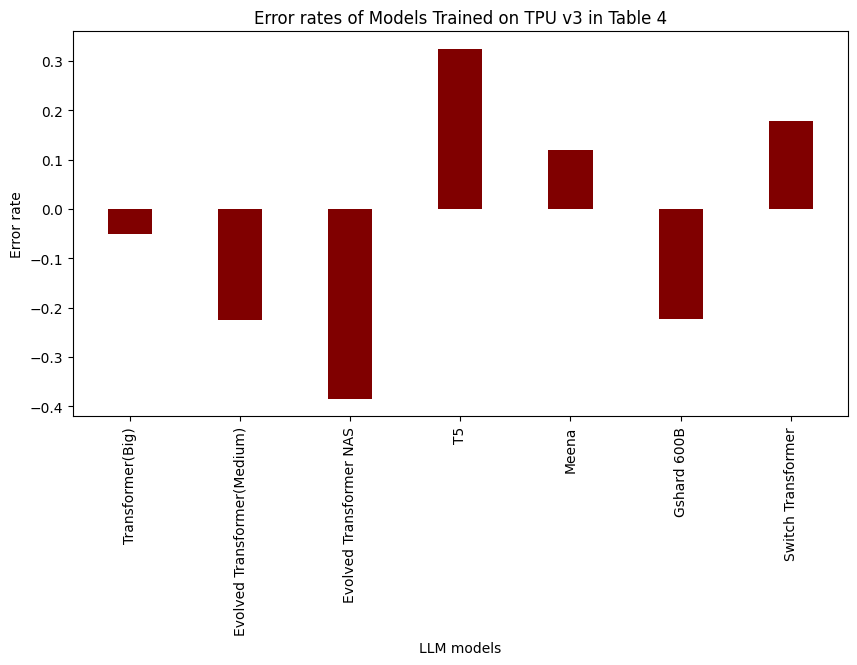

In [17]:
import numpy as np
import matplotlib.pyplot as plt

models = t4.loc[:, "Model"]
errors = t4.loc[:,"prediction error"]

fig = plt.figure(figsize = (10, 5))
plt.xticks(rotation = 90)
# creating the bar plot
plt.bar(models, errors, color ='maroon', width = 0.4)


plt.xlabel("LLM models")
plt.ylabel("Error rate")
plt.title("Error rates of Models Trained on TPU v3 in Table 4")
plt.show()

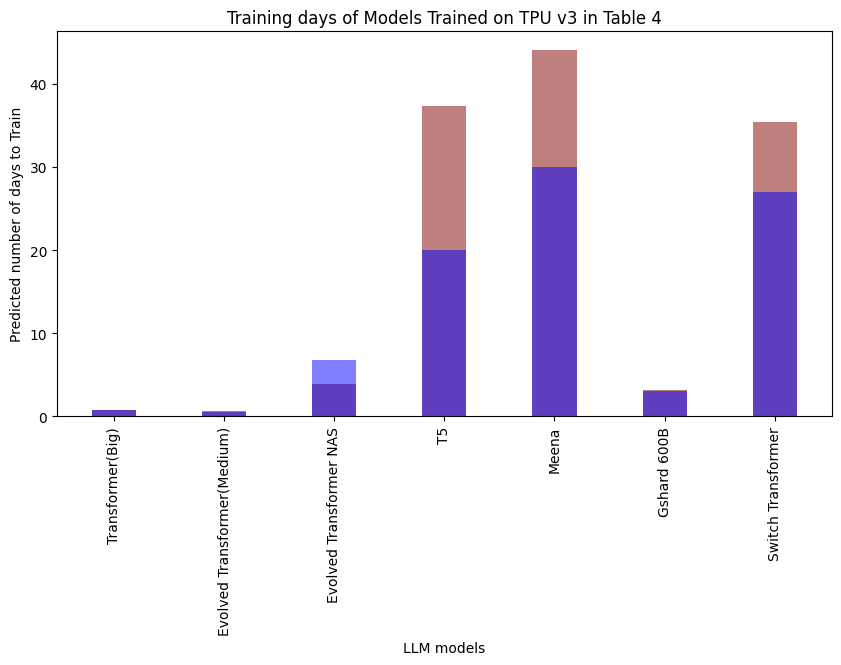

In [18]:
import numpy as np
import matplotlib.pyplot as plt

models = t4.loc[:, "Model"]
days = t4.loc[:,"training time prediction"] / 24
real_days = t4.loc[:,"Training time (days)"]

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(models, days, color ='maroon', alpha = 0.5, width = 0.4)
plt.bar(models, real_days, color ='blue', alpha = 0.5, width = 0.4)
plt.xticks(rotation = 90)

plt.xlabel("LLM models")
plt.ylabel("Predicted number of days to Train")
plt.title("Training days of Models Trained on TPU v3 in Table 4")
plt.show()

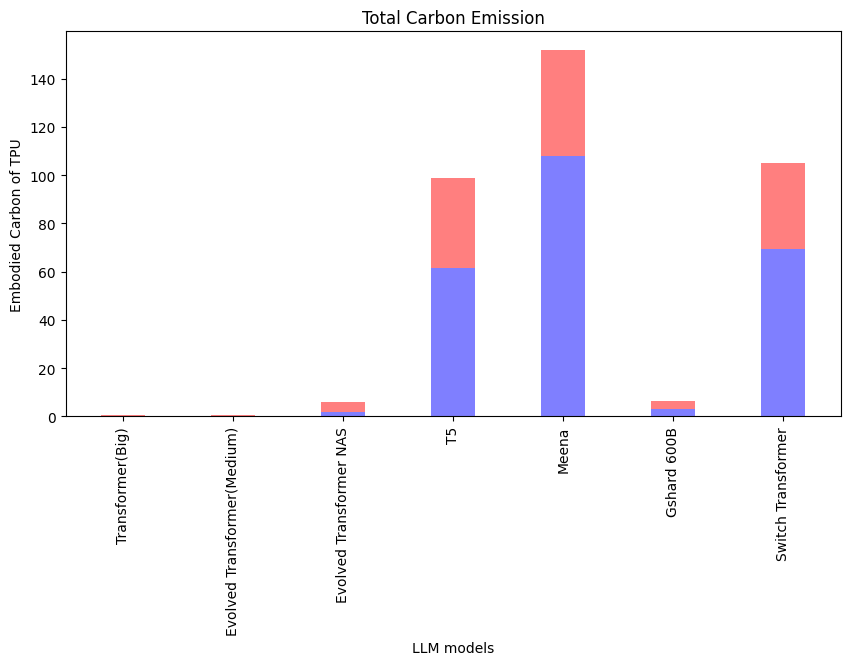

In [25]:
import numpy as np
import matplotlib.pyplot as plt

models = t4.loc[:, "Model"]
embodied = t4.loc[:,"embodied prediction"]
use_tCO2 = t4.loc[:,"predicted tCO2"]
#ratio = embodied / (embodied + use_tCO2)

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(models, days, color ='red', alpha = 0.5, width = 0.4, bottom = use_tCO2)
plt.bar(models, use_tCO2, color ='blue', alpha = 0.5, width = 0.4)
plt.xticks(rotation = 90)

plt.xlabel("LLM models")
plt.ylabel("Embodied Carbon of TPU")
plt.title("Total Carbon Emission")
plt.show()

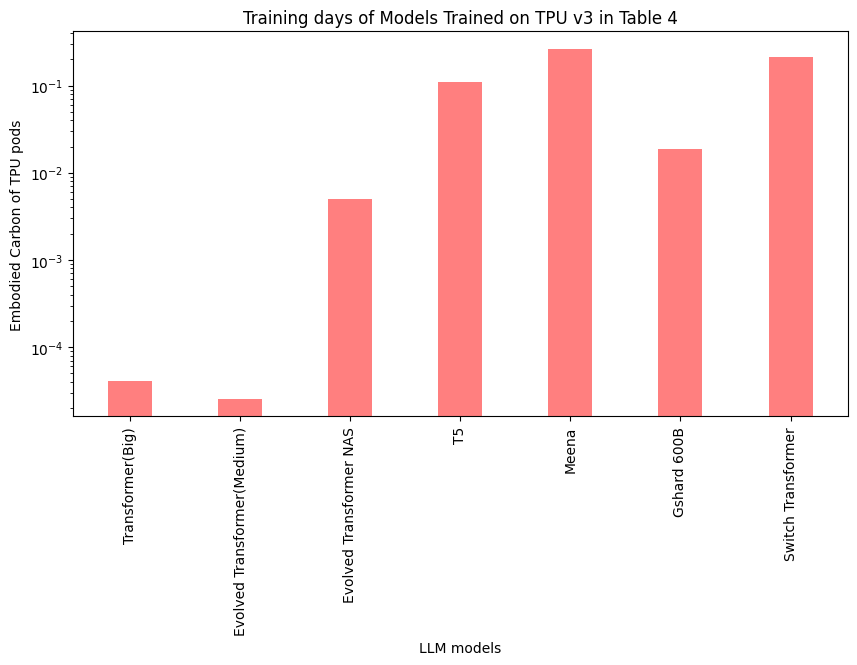

In [20]:
import numpy as np
import matplotlib.pyplot as plt

models = t4.loc[:, "Model"]
embodied = t4.loc[:,"embodied prediction"]
use_tCO2 = t4.loc[:,"predicted tCO2"]

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(models, embodied, color ='red', alpha = 0.5, width = 0.4)
plt.xticks(rotation = 90)

plt.xlabel("LLM models")
plt.ylabel("Embodied Carbon of TPU pods")
plt.yscale('log')
plt.title("Training days of Models Trained on TPU v3 in Table 4")
plt.show()

In [21]:
# 7 kg per GPU
7 * 1024 * (30 / (365 * 3)) / 1000


0.1963835616438356